In [1]:
import torch, random, numpy as np

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def get_top_k(logits, top_k=5):
    """
    logits: (B, T, vocab_size)
    Returns a list of top-k token IDs for the last position, e.g. [id1, id2,...].
    """
    last_logits = logits[:, -1, :]       # shape (B, vocab_size)
    probs = torch.softmax(last_logits, dim=-1)
    top_vals, top_indices = probs.topk(top_k, dim=-1)
    # top_indices is shape (B, top_k). For B=1, we do top_indices[0].tolist().
    return top_indices[0].tolist()

def detect_ngram_copy(seq_ids: torch.Tensor, n=3):
    """
    Minimal function that tries to find n-gram copy scenario
    (just a placeholder – adapt to your real logic)
    """
    T = seq_ids.size(1)  # shape (B=1, T)
    if T < n:
        return None, None
    # 1) last token
    last_token = seq_ids[0, -1].item()
    # 2) find earlier positions of last_token
    possible_pos = (seq_ids[0, :-1] == last_token).nonzero().view(-1)
    if possible_pos.numel() == 0:
        return None, None
    # 3) check (n-1) context
    n_minus_1 = n - 1
    context_needed = seq_ids[0, -(n_minus_1+1):-1]  # last n-1 tokens
    matched_pos = None
    for pos in reversed(possible_pos):
        if pos >= n_minus_1:
            candidate = seq_ids[0, pos-n_minus_1:pos]
            if torch.all(candidate == context_needed):
                matched_pos = pos.item()
                break
    if matched_pos is None:
        return None, None
    else:
        return matched_pos

In [2]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return  intersection / union


def get_acc(info_lst):
    jcc_ult = []
    acc_ult = []

    for data in info_lst:
        acc_lst = []
        jc_lst = []
        for step in data.keys():
            copy = data[step]['copy']
            original = data[step]['original']

            jaccard_score = jaccard_similarity(copy, original)
            jc_lst.append(jaccard_score)

            acc_score = 1 if copy[0] == original[0] else 0
            acc_lst.append(acc_score)

        jcc_ult.append(jc_lst)
        acc_ult.append(acc_lst)
    
    def cal_avg(lsts):
        avg_lst = []
        for lst in lsts:
            if len(lst) == 0:
                continue
            avg_lst.append(sum(lst) / len(lst))
        return sum(avg_lst) / len(avg_lst)

    avg_jcc = cal_avg(jcc_ult)
    avg_acc = cal_avg(acc_ult)

    return avg_jcc, avg_acc

In [3]:
# Import stuff
import torch
import torch.nn as nn
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm

from jaxtyping import Float
from functools import partial

# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix

import torch
torch.set_grad_enabled(False)

In [4]:
from transformer_lens import HookedTransformer
import torch
from transformers import GPT2Tokenizer, Qwen2Tokenizer


# load model and tokenizer
model = HookedTransformer.from_pretrained("Qwen/Qwen2.5-3B")
# tokenizer = Qwen2Tokenizer.from_pretrained("Qwen/Qwen2.5-3B")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model Qwen/Qwen2.5-3B into HookedTransformer


In [5]:
import time
import torch
from tqdm import tqdm
from collections import defaultdict

def mini_acc(dict_pred_info):
    acc_lst = []
    for step in dict_pred_info.keys():
        copy = dict_pred_info[step]['copy']
        original = dict_pred_info[step]['original']

        acc_score = 1 if copy[0] == original[0] else 0
        acc_lst.append(acc_score)
    return sum(acc_lst) / len(acc_lst)

def has_required_spaces(seq: str, seqlen = 6) -> bool:
    """
    Returns True if the sequence has an occurrence of 'is' or 'are'
    that is preceded (anywhere earlier in the sequence) by at least 6 tokens that are exactly 'space'.
    
    Examples:
      'There space space space space space oh space is a cat.' -> True
      'There space are many cats.' -> False
      'There is a cat.' -> False
      'There space space space space space space is a cat.' -> True
      'There spaces are many cats.' -> False
    """
    tokens = seq.split()
    # check if sentence only has 1 is or are
    if tokens.count("is") + tokens.count("are") != 1:
        return False
    for i, token in enumerate(tokens):
        if token in {"is", "are"}:
            # Count how many tokens before this occurrence are exactly "space"
            if len(tokens[:i]) >= seqlen:
                return True
    return False

def text_preprocess(text):
    """Given a text, replace ' is ' by ' are ', and vice versa. Return the corrupted text, and the text until the first is/are."""
    text = text.strip()
    if ' is ' in text:
        corrupted_text = text.replace(' is ', ' are ', 1)
    elif ' are ' in text:
        corrupted_text = text.replace(' are ', ' is ', 1)
    
    # find position of first is/are and return text before that
    first_is = text.find(' is ')
    first_are = text.find(' are ')
    if first_is == -1 and first_are == -1:
        return None
    elif first_is == -1:
        return corrupted_text, text[:first_are], 'are'
    elif first_are == -1:
        return corrupted_text, text[:first_is], 'is'
    
    return corrupted_text, text[:min(first_is, first_are)]

def ngram(n, model, skip_up_to, max_steps, extra_steps, k, edited_phrases):

    print("n-gram: ", n)
    print("Skip layers: ", skip_up_to)

    info_lst = []
    failed_lst = []

    total_failed_by_prepocess = 0
    total_failed_as_ulsolvable = 0
    total_solvable_og = 0
    total_solvable_pt = 0
    total_matches = []

    num_matched = 0
    total_steps = 0

    for edited in tqdm(edited_phrases):

        if total_solvable_og == 100:
            break

        if not has_required_spaces(edited, seqlen=7):
            continue

        # preprocess text
        edited = text_preprocess(edited)
        if edited is None:
            total_failed_by_prepocess += 1
            continue
        corrupted_text, pre_isare, correct_tobe = edited
        prompt = f"Please fix grammar of the following text: '{corrupted_text}'. The correct text is: {pre_isare}"

        # edited_ids = tokenizer.encode(edited, return_tensors='pt')
        # steps = extra_steps + edited_ids.size(1)
        # if steps > max_steps:
        #     steps = max_steps
        # total_steps += steps
        steps = 1

        dict_pred_info = defaultdict(dict)

        for step_i in range(steps):
            prompt_tokens = model.to_tokens(prompt)

            if step_i != 0:
                prompt_tokens = model.to_tokens(prompt, prepend_bos=False)

            # run on the prompt once with cache to store activations to patch in later
            og_logits, og_cache = model.run_with_cache(prompt_tokens)
            # get the top k tokens
            og_topk_indices = get_top_k(og_logits, k)
            # get the highest prob token
            og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

            # check if model can solve the task
            decoded_og_next_token = model.to_string(og_next_token)[0]
            if 'are' in decoded_og_next_token and correct_tobe == 'are':
                total_solvable_og += 1
            elif 'is' in decoded_og_next_token and correct_tobe == 'is':
                total_solvable_og += 1
            else:
                continue

            # detect copy scenario
            t_matched_1st = detect_ngram_copy(prompt_tokens, n=n)
            t_matched_2nd = detect_ngram_copy(prompt_tokens[:,:-1], n=n)
            t_matched_3nd = detect_ngram_copy(prompt_tokens[:,:-2], n=n)
            
            if t_matched_1st is not None and t_matched_2nd is not None:
                pos_matched = [t_matched_1st, t_matched_2nd, t_matched_3nd]
                pos_current = [len(prompt_tokens[0])-1, len(prompt_tokens[0])-2, len(prompt_tokens[0])-3]
                
                num_matched += 1

                def residual_stream_patching_hook(
                    resid_pre: Float[torch.Tensor, "batch pos d_model"],
                    hook: HookPoint,
                    pos_matched: list,
                    pos_current: list
                ) -> Float[torch.Tensor, "batch pos d_model"]:
                    # Each HookPoint has a name attribute giving the name of the hook.
                    clean_resid_pre = og_cache[hook.name]
                    resid_pre[:, pos_current, :] = clean_resid_pre[:, pos_matched, :]
                    return resid_pre
                
                try:
                    # Use functools.partial to create a temporary hook function with the position fixed
                    temp_hook_fn = partial(residual_stream_patching_hook, pos_matched=pos_matched, pos_current=pos_current)
                    # Run the model with the patching hook
                    patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                        (utils.get_act_name("resid_pre", skip_up_to), temp_hook_fn)
                    ])
                except:
                    continue

                # def v_patching_hook(
                #     resid_pre: Float[torch.Tensor, "batch pos head_index d_head"],
                #     hook: HookPoint,
                #     position: int
                # ) -> Float[torch.Tensor, "batch pos head_index d_head"]:
                #     # Each HookPoint has a name attribute giving the name of the hook.
                #     clean_resid_pre = og_cache[hook.name]
                #     resid_pre[:, -1, :, :] = clean_resid_pre[:, position, :, :]
                #     return resid_pre
                
                # for layer in range(skip_up_to):
                #     # Use functools.partial to create a temporary hook function with the position fixed
                #     temp_hook_fn = partial(v_patching_hook, position=t_matched)
                #     # Run the model with the patching hook
                #     patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                #         (utils.get_act_name("v", layer), temp_hook_fn)
                #     ])
                
                pt_topk_indices = get_top_k(patched_logits, k)
                # get the highest prob token
                pt_next_token = torch.tensor([pt_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

                # check if model can solve the task
                decoded_pt_next_token = model.to_string(pt_next_token)[0]
                if 'are' in decoded_pt_next_token and correct_tobe == 'are':
                    total_solvable_pt += 1
                elif 'is' in decoded_pt_next_token and correct_tobe == 'is':
                    total_solvable_pt += 1

                if torch.equal(og_next_token, pt_next_token):
                    total_matches.append(1)
                else:
                    total_matches.append(0)

                # # append the token to the sequence
                # pt_prompt_tokens = torch.cat([prompt_tokens, pt_next_token], dim=1)
                # # deocde the token
                # pt_prompt = model.to_string(pt_prompt_tokens)[0]      
                # print('PT:\n')
                # print(pt_prompt)

                dict_pred_info[step_i]['original'] = og_topk_indices
                dict_pred_info[step_i]['copy'] = get_top_k(patched_logits, k)

            # # append the token to the sequence
            # prompt_tokens = torch.cat([prompt_tokens, og_next_token], dim=1)
            # # deocde the token
            # prompt = model.to_string(prompt_tokens)[0]
            # print('OG:\n')
            # print(prompt)
            # print("Avg accuracy: ", total_solvable_pt / total_solvable_og)
            # a

        info_lst.append(dict_pred_info)
        
    jcc, acc = get_acc(info_lst)
    print("Avg jaccard similarity: ", jcc)
    print("Avg accuracy 2: ", acc)
    print("Avg accuracy 3: ", sum(total_matches) / len(total_matches))
    return jcc, acc, sum(total_matches) / len(total_matches)

    # print("Number of matched tokens: ", num_matched)
    # print("Total steps: ", total_steps)
    # print("%matched tokens per program: ", num_matched/total_steps)
    # print("Avg matched tokens per program: ", num_matched/len(base_sents))
    # print("Avg jaccard similarity: ", jcc)
    # print("Avg accuracy: ", acc)
    # print("Total failed programs: ", total_failed)

    # return info_lst, failed_lst, num_matched, jcc, acc

In [6]:
from datasets import load_from_disk
from tqdm import tqdm

# Load the dataset from disk
num_samples = 2000
subset = load_from_disk("/home/longnhat/workspace_phu/CopyMech/english_insertions")
prompt_list = []

base_sents = subset['train']['base_sentence'][:num_samples]
phrases = subset['train']['phrase'][:num_samples]
edited_sents = subset['train']['edited_sentence'][:num_samples]

import gc
del subset
gc.collect()

0

In [7]:
seed = 5
extra_steps = 5
max_steps = 1024
k=100
seed_everything(seed)

jcc = []
acc = []

ns = [5]
# skip_up_to = [5, 10, 15, 20, 25, 30]
skip_up_to = [5,6,7,8,9,10]
info_lst = {}
for n in ns:
    info_lst[n] = {}
    for skip in skip_up_to:
        info_lst[n][skip] = {}
        outputs = ngram(n, model, skip, max_steps, extra_steps, k, edited_sents)
        jcc.append(outputs[0])
        acc.append(outputs[1])
        print("-----------------------------------")

n-gram:  5
Skip layers:  5


 55%|█████▍    | 1099/2000 [00:15<00:12, 71.13it/s]


Avg jaccard similarity:  0.9261927847149858
Avg accuracy 2:  0.9797979797979798
Avg accuracy 3:  0.9797979797979798
-----------------------------------
n-gram:  5
Skip layers:  6


 55%|█████▍    | 1099/2000 [00:15<00:12, 71.28it/s] 


Avg jaccard similarity:  0.8013317287787761
Avg accuracy 2:  0.8686868686868687
Avg accuracy 3:  0.8686868686868687
-----------------------------------
n-gram:  5
Skip layers:  7


 55%|█████▍    | 1099/2000 [00:15<00:12, 70.57it/s]


Avg jaccard similarity:  0.7939294426684815
Avg accuracy 2:  0.8787878787878788
Avg accuracy 3:  0.8787878787878788
-----------------------------------
n-gram:  5
Skip layers:  8


 55%|█████▍    | 1099/2000 [00:15<00:12, 70.58it/s] 


Avg jaccard similarity:  0.7758704300340159
Avg accuracy 2:  0.8383838383838383
Avg accuracy 3:  0.8383838383838383
-----------------------------------
n-gram:  5
Skip layers:  9


 55%|█████▍    | 1099/2000 [00:15<00:12, 70.07it/s]


Avg jaccard similarity:  0.7692257789265798
Avg accuracy 2:  0.8383838383838383
Avg accuracy 3:  0.8383838383838383
-----------------------------------
n-gram:  5
Skip layers:  10


 55%|█████▍    | 1099/2000 [00:15<00:12, 69.70it/s]

Avg jaccard similarity:  0.7707593134937785
Avg accuracy 2:  0.8585858585858586
Avg accuracy 3:  0.8585858585858586
-----------------------------------


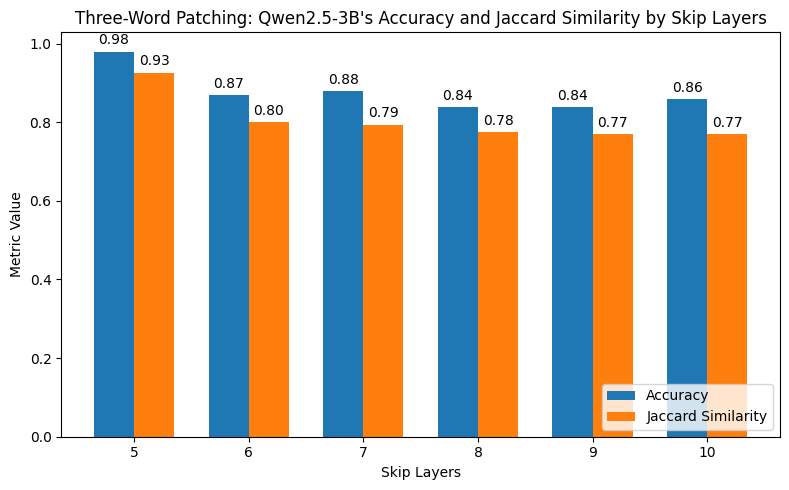

In [8]:
# Accuracy 3 values
accuracy3 = acc

# Jaccard Similarity values
jaccard_similarity = jcc

import matplotlib.pyplot as plt
import numpy as np

def plot_skip_layer_metrics(skip_layers, accuracy3, jaccard_similarity, model_name, schema):
    """
    Plots a grouped bar chart of Accuracy 3 and Jaccard Similarity for different skip layers.
    
    Parameters:
      skip_layers (list): List of skip layer values (e.g., [5, 10, 15, 20, 25, 30]).
      accuracy3 (list): List of Accuracy 3 values corresponding to each skip layer.
      jaccard_similarity (list): List of Jaccard similarity values corresponding to each skip layer.
    """
    # Create an array with the positions for each skip layer on the x-axis.
    x = np.arange(len(skip_layers))
    width = 0.35  # width of each bar

    # Create the plot and two sets of bars.
    fig, ax = plt.subplots(figsize=(8, 5))
    bars_acc = ax.bar(x - width/2, accuracy3, width, label='Accuracy')
    bars_jacc = ax.bar(x + width/2, jaccard_similarity, width, label='Jaccard Similarity')

    # Label the axes and add a title
    ax.set_xlabel('Skip Layers')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'{schema}: {model_name}\'s Accuracy and Jaccard Similarity by Skip Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(skip_layers)
    ax.legend(loc = 'lower right')

    # Add numerical labels above the bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(bars_acc)
    autolabel(bars_jacc)

    plt.tight_layout()
    plt.show()

# Example data based on the results:
skip_layers = skip_up_to

plot_skip_layer_metrics(skip_layers, accuracy3, jaccard_similarity, model_name="Qwen2.5-3B", schema="Three-Word Patching")
